In [1]:
!nvidia-smi

Sat Oct  5 17:54:40 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   36C    P0    87W / 400W |  14915MiB / 81251MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from transformers import AutoTokenizer, AutoModel, GPT2LMHeadModel, GPT2Tokenizer
from sklearn.decomposition import PCA
from torch import nn
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import torch
import matplotlib.pyplot as plt
import time
import pandas as pd

In [3]:
knowledgebase_url = 'https://github.com/AndiAlifs/FLUENT-Chatbot-2023/raw/main/KnowledgeBaseFilkom.xlsx'
# knowledgebase_url = 'https://github.com/AndiAlifs/FLUENT-Chatbot-2023/raw/main/KnowledgeBaseFilkom_simple.xlsx'
knowledgebase = pd.read_excel(knowledgebase_url)

qa_paired = knowledgebase.drop(columns=knowledgebase.columns.drop(['Pertanyaan', 'Jawaban']))
qa_paired.dropna(inplace=True)
qa_paired

,Pertanyaan,Jawaban
0,email Fitra A. Bachtiar,fitra.bachtiar[at]ub.ac.id
1,NIK/NIP Fitra A. Bachtiar,198406282019031006
2,nama lengkap Fitra A. Bachtiar,Dr.Eng. Fitra A. Bachtiar
3,Departemen Fitra A. Bachtiar,Departemen Teknik Informatika
4,Program Studi Fitra A. Bachtiar,S2 Ilmu Komputer
...,...,...
1229,Apa Manfaat Konseling FILKOM ?,1. Masalah ditangani oleh ahli yang kompeten d...
1230,Berikan informasi mengenai Layanan Konseling,Informasi mengenai Layanan Konseling dapat dia...
1231,Siapa Konselor Bimbingan dan Konseling di FILK...,Ada 2 konselor Bimbingan dan Konseling di FILK...
1232,Siapa Koordinator Konselor Sebaya ?,Koordinator Konselor Sebaya adalah Muhammad Da...


In [4]:
enc_tokenizer = AutoTokenizer.from_pretrained('firqaaa/indo-sentence-bert-base')
enc_model = AutoModel.from_pretrained('firqaaa/indo-sentence-bert-base')

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
# model_name_dec = 'flax-community/gpt2-medium-indonesian'
model_name_dec = 'indonesian-nlp/gpt2-medium-indonesian'

dec_model = GPT2LMHeadModel.from_pretrained(model_name_dec)
dec_tokenizer = GPT2Tokenizer.from_pretrained(model_name_dec)

dec_tokenizer.add_special_tokens({'pad_token': '[PAD]',
                                    'bos_token': '[BOS]',
                                    'eos_token': '[EOS]',
                                    'sep_token': '[SEP]',})

# Add a new token to the tokenizer
dec_model.config.pad_token_id = dec_tokenizer.pad_token_id
dec_model.config.bos_token_id = dec_tokenizer.bos_token_id
dec_model.config.eos_token_id = dec_tokenizer.eos_token_id
dec_model.config.sep_token_id = dec_tokenizer.sep_token_id

dec_model.resize_token_embeddings(len(dec_tokenizer))

Embedding(50262, 1024)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
enc_model = enc_model.to(device)
dec_model = dec_model.to(device)

In [7]:
qa_paired_test = qa_paired[:40]
qa_paired_test = qa_paired_test.applymap(lambda x: x.lower() if isinstance(x, str) else x)
qa_paired_test['Jawaban'] = qa_paired_test['Jawaban'].apply(lambda x: '[BOS]' + x + '[EOS]')
qa_paired_test = qa_paired_test.reset_index(drop=True)
qa_paired_test

,Pertanyaan,Jawaban
0,email fitra a. bachtiar,[BOS] fitra.bachtiar[at]ub.ac.id[EOS]
1,nik/nip fitra a. bachtiar,[BOS]198406282019031006[EOS]
2,nama lengkap fitra a. bachtiar,[BOS]dr.eng. fitra a. bachtiar[EOS]
3,departemen fitra a. bachtiar,[BOS]departemen teknik informatika[EOS]
4,program studi fitra a. bachtiar,[BOS]s2 ilmu komputer[EOS]
5,bidang penelitian fitra a. bachtiar,"[BOS]affective computing, affective engineerin..."
6,nama awal fakultas ilmu komputer (filkom),[BOS]program teknologi informasi dan ilmu komp...
7,rujukan surat keputusan sk dikti dibentuk ptiik,[BOS] sk dikti no.163/kep/dikti/2007 [EOS]
8,surat keputusan sk rektor bentuk ptiik,[BOS]surat keputusan rektor universitas brawij...
9,tanggal dibentuk ptiik,[BOS]27 oktober 2011[EOS]


In [8]:
class FLUENTSOTA(nn.Module):
    def __init__(self, enc_model, dec_model, enc_tokenizer, dec_tokenizer, max_length=200):
        super(FLUENTSOTA, self).__init__()
        self.enc_model = enc_model
        self.dec_model = dec_model
        self.enc_tokenizer = enc_tokenizer
        self.dec_tokenizer = dec_tokenizer
        self.enc_mapper = nn.Linear(768, 1024)
        self.enc_mapper2 = nn.Linear(1024, 1024)
        self.max_length = max_length
    
    def encoding(self, sentence):
        tokens = self.enc_tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=self.max_length)
        tokens = tokens.to(device)
        with torch.no_grad():
            output = self.enc_model(**tokens)
        enc_logits = output.last_hidden_state.mean(dim=1)
        enc_logits = self.enc_mapper(enc_logits).to(device)
        enc_logits = self.enc_mapper2(enc_logits).to(device)
        return enc_logits

    def get_embedding(self, sentence):
        tokens = self.dec_tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=self.max_length)
        tokens = tokens.to(device)
        wte = self.dec_model.get_input_embeddings()
        return wte(tokens['input_ids'])

    def dec_tokenizer(self, sentence):
        tokens = self.dec_tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=self.max_length)
        return tokens

    def decoding(self, enc_logits, target):
        embed = self.get_embedding(target)
        pref_with_embed = torch.cat((enc_logits.unsqueeze(0), embed), dim=1)
        output = self.dec_model(inputs_embeds=pref_with_embed)
        return output

    def decoding_train(self, enc_logits, target, target_with_pre):
        embed = self.get_embedding(target)
        pref_with_embed = torch.cat((enc_logits.unsqueeze(0), embed), dim=1)
        output = self.dec_model(inputs_embeds=pref_with_embed, labels=target_with_pre)
        return output

    def generate(self, quest):
        enc_logits = self.encoding(quest)
        prefix_se = '[PRE1][BOS]'
        prefix_dec_embed = self.get_embedding(prefix_se)
        
        pref_with_embed = torch.cat((enc_logits.unsqueeze(0), prefix_dec_embed), dim=1)

        output = self.dec_model.generate(   inputs_embeds=pref_with_embed, 
                                            max_length=self.max_length, 
                                            pad_token_id=self.dec_model.config.eos_token_id)
        returned_output = []
        for i in range(len(output[0])):
            if output[0][i] != self.dec_model.config.eos_token_id:
                returned_output.append(output[0][i])
            else:
                break
        return torch.tensor(returned_output).unsqueeze(0)

In [9]:
for param in enc_model.parameters():
    param.requires_grad = False

for param in dec_model.parameters():
    param.requires_grad = False

for param in dec_model.transformer.h[:-15].parameters():
    param.requires_grad = True

for param in enc_model.encoder.layer[:-15].parameters():
    param.requires_grad = True


In [10]:
model = FLUENTSOTA(enc_model, dec_model, enc_tokenizer, dec_tokenizer)
model.to(device)

FLUENTSOTA(
  (enc_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [11]:
all_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
untrainable_params = all_params - trainable_params

print(f'All parameters: {all_params:,}')
print(f'Trainable parameters: {trainable_params:,} ({trainable_params/all_params*100:.2f}%)')
print(f'Untrainable parameters: {untrainable_params:,} ({untrainable_params/all_params*100:.2f}%)')

All parameters: 481,106,688
Trainable parameters: 115,203,072 (23.95%)
Untrainable parameters: 365,903,616 (76.05%)


In [12]:
# pertanyaan = qa_paired_test['Pertanyaan'][:20]
# jawaban = qa_paired_test['Jawaban'][:20]
# jawaban_withpre = qa_paired_test['JawabanWithPre'][:20]

# tokenized_jawaban_withpre = model.dec_tokenizer(jawaban_withpre)
# tokenized_jawaban_withpre = torch.tensor(tokenized_jawaban_withpre['input_ids']).unsqueeze(0)

# enc_logits = model.encoding(pertanyaan)
# # print(enc_logits)
# # print(jawaban)
# # print(tokenized_jawaban_withpre)
# output = model.decoding_train(enc_logits, target=jawaban, target_with_pre=tokenized_jawaban_withpre)

In [13]:
def calculate_bleu(preds, questions, answers):
    bleu_score_1 = 0
    bleu_score_2 = 0
    bleu_score_3 = 0
    bleu_score_4 = 0
    cum_bleu_score_1 = 0
    cum_bleu_score_2 = 0
    cum_bleu_score_3 = 0
    cum_bleu_score_4 = 0

    num_of_rows_calculated = 0
    smoothing_function = SmoothingFunction().method1

    for i, (question, real_answer) in enumerate(zip(questions, answers)):
        # print(f"Question: {question}")
        # print(f"Real Answer: {real_answer}")
        # print(f"Predicted Answer: {preds[i]}")
        refs = [real_answer.split(' ')]
        hyp = preds[i].split(' ')

        bleu_score_1 += sentence_bleu(refs, hyp, weights=(1,0,0,0), smoothing_function=smoothing_function)
        bleu_score_2 += sentence_bleu(refs, hyp, weights=(0,1,0,0), smoothing_function=smoothing_function)
        bleu_score_3 += sentence_bleu(refs, hyp, weights=(0,0,1,0), smoothing_function=smoothing_function)
        bleu_score_4 += sentence_bleu(refs, hyp, weights=(0,0,0,1), smoothing_function=smoothing_function)
        cum_bleu_score_1 += sentence_bleu(refs, hyp, weights=(1,0,0,0), smoothing_function=smoothing_function)
        cum_bleu_score_2 += sentence_bleu(refs, hyp, weights=(0.5,0.5,0,0), smoothing_function=smoothing_function)
        cum_bleu_score_3 += sentence_bleu(refs, hyp, weights=(0.33,0.33,0.33,0), smoothing_function=smoothing_function)
        cum_bleu_score_4 += sentence_bleu(refs, hyp, weights=(0.25,0.25,0.25,0.25), smoothing_function=smoothing_function)

        num_of_rows_calculated+=1

    results = {"1-gram": (bleu_score_1/num_of_rows_calculated),
                "2-gram": (bleu_score_2/num_of_rows_calculated),
                "3-gram": (bleu_score_3/num_of_rows_calculated),
                "4-gram": (bleu_score_4/num_of_rows_calculated),
                "cumulative-1-gram": (cum_bleu_score_1/num_of_rows_calculated),
                "cumulative-2-gram": (cum_bleu_score_2/num_of_rows_calculated),
                "cumulative-3-gram": (cum_bleu_score_3/num_of_rows_calculated),
                "cumulative-4-gram": (cum_bleu_score_4/num_of_rows_calculated)}

    return results

def count_bleu_score(model_count, real_answers, questions):
    preds = []
    for question in questions:
        outputs = model_count.generate(question)
        decoded_output = model_count.dec_tokenizer.decode(outputs[0])
        preds.append(decoded_output)
    return calculate_bleu(preds, questions, real_answers)

In [14]:
bleu_score = pd.DataFrame(columns=['Epoch', '1-gram', '2-gram', '3-gram', '4-gram', 'cumulative-1-gram', 'cumulative-2-gram', 'cumulative-3-gram', 'cumulative-4-gram'])
questions = qa_paired_test['Pertanyaan'].apply(lambda x: x.lower().replace('[BOS]', '').replace('[EOS]', '')).to_list()
answers = qa_paired_test['Jawaban'].apply(lambda x: x.replace('[BOS]', '').replace('[EOS]', '').lower().strip()).to_list()

epochs = 500
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

for ep in range(epochs):
    torch.cuda.empty_cache()

    total_loss = 0
    for instance in qa_paired_test.iterrows():
        # print("---------------")
        optimizer.zero_grad()

        pertanyaan = instance[1]['Pertanyaan']
        jawaban = instance[1]['Jawaban']
        jawaban_withpre = '[PRE1]' + jawaban

        tokenized_jawaban_withpre = model.dec_tokenizer(jawaban_withpre)
        tokenized_jawaban_withpre = torch.tensor(tokenized_jawaban_withpre['input_ids']).unsqueeze(0)

        enc_logits = model.encoding(pertanyaan)
        output = model.decoding_train(enc_logits, target=jawaban, target_with_pre=tokenized_jawaban_withpre)

        loss = output.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    print(f'Epoch {ep+1}/{epochs} - Loss: {total_loss:.4f}')
    if (ep+1) % 10 == 0:
        print(f'\n-----------------------------------------')
        test_question = qa_paired_test['Pertanyaan'].iloc[21]
        outputs = model.generate(test_question)
        decoded_output = model.dec_tokenizer.decode(outputs[0])
        print(f'Q >>> {test_question}')
        print(f'A <<< {decoded_output}')
        test_question = qa_paired_test['Pertanyaan'].iloc[13]
        outputs = model.generate(test_question)
        decoded_output = model.dec_tokenizer.decode(outputs[0])
        print(f'Q >>> {test_question}')
        print(f'A <<< {decoded_output}')
        test_question = qa_paired_test['Pertanyaan'].iloc[14]
        outputs = model.generate(test_question)
        decoded_output = model.dec_tokenizer.decode(outputs[0])
        print(f'Q >>> {test_question}')
        print(f'A <<< {decoded_output}')
        print(f'-----------------------------------------\n')

    if (ep+1) % 10 == 0:
        bleu_result = count_bleu_score(model, answers, questions)
        bleu_score = pd.concat([bleu_score, pd.DataFrame({'Epoch': ep+1, **bleu_result}, index=[len(bleu_score)])], ignore_index=True)


Epoch 1/500 - Loss: 171.7337
Epoch 2/500 - Loss: 123.4501
Epoch 3/500 - Loss: 92.2785
Epoch 4/500 - Loss: 71.7322
Epoch 5/500 - Loss: 57.0965
Epoch 6/500 - Loss: 46.6338
Epoch 7/500 - Loss: 37.3646
Epoch 8/500 - Loss: 32.6111
Epoch 9/500 - Loss: 24.7575
Epoch 10/500 - Loss: 18.5039

-----------------------------------------
Q >>> wakil dekan bidang akademik / wakil dekan 1
A <<<  surachman, s.t., m.t.
Q >>> visi filkom
A <<< konversi satuan pendidikan tinggi adalah perubahan bentuk perguruan tinggi dari perguruan tinggi yang bersifat otonom menjadi perguruan tinggi yang bersifat kolaboratif.
d[BOS].ac.id
Q >>> misi filkom
A <<<  guritno, s.t., m.t., ph.d.
-----------------------------------------

Epoch 11/500 - Loss: 15.3506
Epoch 12/500 - Loss: 13.6621
Epoch 13/500 - Loss: 10.9280
Epoch 14/500 - Loss: 12.8046
Epoch 15/500 - Loss: 11.8145
Epoch 16/500 - Loss: 7.8353
Epoch 17/500 - Loss: 8.4459
Epoch 18/500 - Loss: 5.8220
Epoch 19/500 - Loss: 8.1635
Epoch 20/500 - Loss: 5.3413

-------

In [15]:
bleu_score.to_excel('bleu_score_041024_nopre.xlsx', index=False)

In [16]:
bleu_score

,Epoch,1-gram,2-gram,3-gram,4-gram,cumulative-1-gram,cumulative-2-gram,cumulative-3-gram,cumulative-4-gram
0,10,0.018994,0.009068,0.002313,0.004542,0.018994,0.012356,0.006885,0.005997
1,20,0.065980,0.034623,0.029883,0.032804,0.065980,0.042914,0.036230,0.034751
2,30,0.038715,0.026631,0.027385,0.029625,0.038715,0.029619,0.028787,0.028873
3,40,0.047625,0.028164,0.028783,0.030649,0.047625,0.033343,0.031573,0.030923
4,50,0.044186,0.012631,0.006460,0.010169,0.044186,0.021720,0.014219,0.012456
5,60,0.087789,0.046983,0.034104,0.033497,0.087789,0.058095,0.045851,0.040367
6,70,0.086379,0.066483,0.054330,0.057519,0.086379,0.072980,0.062929,0.061019
7,80,0.138346,0.108312,0.082362,0.088665,0.138346,0.119236,0.098822,0.095098
8,90,0.164835,0.129141,0.109225,0.115630,0.164835,0.140643,0.124182,0.120798
9,100,0.160706,0.128707,0.108734,0.115045,0.160706,0.139313,0.123192,0.119961


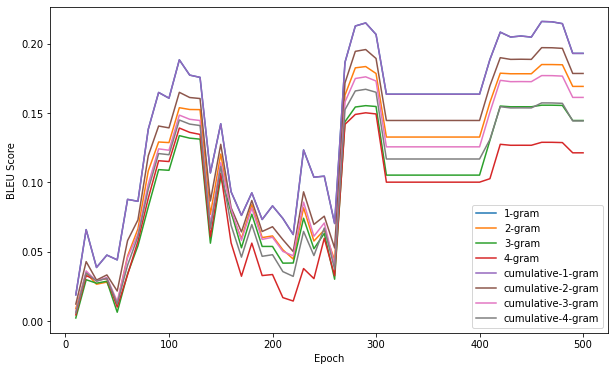

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(bleu_score['Epoch'], bleu_score['1-gram'], label='1-gram')
plt.plot(bleu_score['Epoch'], bleu_score['2-gram'], label='2-gram')
plt.plot(bleu_score['Epoch'], bleu_score['3-gram'], label='3-gram')
plt.plot(bleu_score['Epoch'], bleu_score['4-gram'], label='4-gram')
plt.plot(bleu_score['Epoch'], bleu_score['cumulative-1-gram'], label='cumulative-1-gram')
plt.plot(bleu_score['Epoch'], bleu_score['cumulative-2-gram'], label='cumulative-2-gram')
plt.plot(bleu_score['Epoch'], bleu_score['cumulative-3-gram'], label='cumulative-3-gram')
plt.plot(bleu_score['Epoch'], bleu_score['cumulative-4-gram'], label='cumulative-4-gram')
plt.xlabel('Epoch')
plt.ylabel('BLEU Score')
plt.legend()
# add number for each 100 epoch

In [31]:
test_question = "fitra bachtiar penelitian apa "
outputs = model.generate(test_question)
decoded_output = model.dec_tokenizer.decode(outputs[0])
print(f'Q >>> {test_question}')
print(f'A <<< {decoded_output}')

Q >>> fitra bachtiar penelitian apa 
A <<< affective computing, affective engineering, intelligent system, data mining, educational data mining


In [34]:
test_question = "ketua bpj teh saha ieu"
outputs = model.generate(test_question)
decoded_output = model.dec_tokenizer.decode(outputs[0])
print(f'Q >>> {test_question}')
print(f'A <<< {decoded_output}')

Q >>> ketua bpj teh saha ieu
A <<< berlaku penuhantiemayoto, s.t., m.t.


In [44]:
test_question = "kepala program studi sarjana sistem informasi teh saha"
outputs = model.generate(test_question)
decoded_output = model.dec_tokenizer.decode(outputs[0])
print(f'Q >>> {test_question}')
print(f'A <<< {decoded_output}')

Q >>> kaprodi sarjana sistem informasi teh saha
A <<<  sk dikti no.163/kep/dikti/2007 


In [30]:
for i in range(len(qa_paired_test)):
    test_question = qa_paired_test['Pertanyaan'].iloc[i]
    outputs = model.generate(test_question)
    decoded_output = model.dec_tokenizer.decode(outputs[0])
    qa_paired_test.loc[i, 'Predicted Answer'] = decoded_output

In [31]:
torch.save(model.state_dict(), 'FLUENTSOTA_051024.pth')
qa_paired_test.to_excel('FLUENTSOTA_051024_RESULT.xlsx', index=False)